In [23]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
from matplotlib.colors import LogNorm

c = const.c.cgs.value

In [46]:
outdir = '/Users/yaolun/data/hh168_texes/Dec16/22/analysis/'

## Quick look of the data

### This is the image coadd from 4 files with 16 nod pairs and 10 files with 32 nod pairs

We were doing nodding along the slit.  So 16 nod pairs result in 6*16*2=192 seconds on-source time.

The total on-source time for the file examined in below is 4608 seconds (76.8 minutes).

The nod is 10 arcsec

-0.000958675


[None, None, None, None, None, None, None, None]

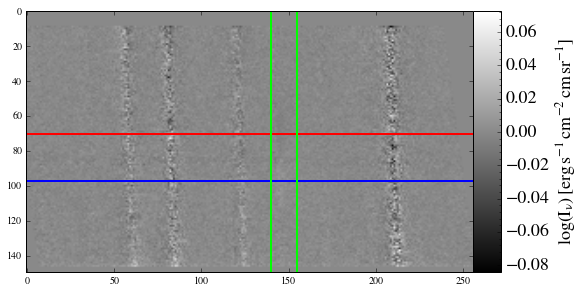

In [172]:
filename = '/Users/yaolun/data/hh168_texes/Dec16/22/fits/hh168.lowall.fits'

hdulist = fits.open(filename)
im = hdulist[0].data[0:150,:]
wno = hdulist[1].data
wave = 1/wno *1e4 # in um
print np.mean(wave[1:]-wave[0:-1])
res = abs(np.mean(wave[1:]-wave[0:-1]))
pltscale = hdulist[0].header['PLTSCL']
# [Ne II] rest frame wavelength: 12.813548 um
dv = (12.813548 - wave) / 12.813548 * c/1e5

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im_plot = ax.imshow(im, cmap='gray') #, norm=LogNorm(vmin=0.005, vmax=0.2)

# draw lines to identify the regions for adding
# convert 10 arcsec nod into pixel scale
nod_pix = 10.0/pltscale
pos_peak = 70
ax.axhline(pos_peak, color='r', linewidth=2)
ax.axhline(pos_peak+nod_pix, color='b', linewidth=2)

# identify where is the Ne II
ax.axvline(140, color='Lime', linewidth=2)
ax.axvline(155, color='Lime', linewidth=2)

cax = fig.add_axes([0.9, 0.21, 0.05, 0.605])
cb = fig.colorbar(im_plot, cax=cax)
cb.solids.set_edgecolor('face')
cb.ax.minorticks_on()
cb.ax.set_ylabel(r'$\rm{log(I_{\nu})\,[erg\,s^{-1}\,cm^{-2}\,cm\,sr^{-1}]}$',fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=18)


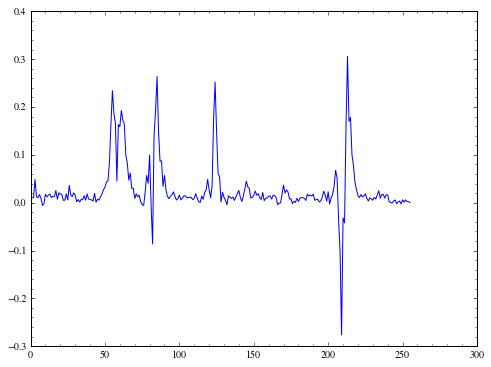

In [96]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

x_pix = np.arange(0,256)
ax.plot(x_pix, np.sum(im, axis=0))
ax.minorticks_on()

In [169]:
hdulist[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  256                                                  
NAXIS2  =                  252                                                  
EXTEND  =                    T                                                  
COMMENT   The primary HDU contains a 2-D spectral-spatial image                 
COMMENT   The primary HDU is followed by four 1-D IMAGE extensions              
COMMENT   giving the wavenumber scale (EXTNAME = WAVENUMBER),                   
COMMENT   the extracted flux spectrum (EXTNAME = FLUX),                         
COMMENT   the calculated 1-sigma noise in the flux (NOISE),                     
COMMENT   and the telluric transmission spectrum calculated from                
COMMENT   (black-sky)/black 

## Try to find where to add positive and negative peaks.

Get the number of pixels along the slit

pixel number 11 to 146.  That's 146-11+1 = 136 pixels

In [ ]:
filename = '/Users/yaolun/data/hh168_texes/Dec16/22/fits/hh168.lowall.fits'

hdulist = fits.open(filename)
im_all = hdulist[0].data

# plt.imshow(im_all)

collapse_im = np.sum(im_all, axis=1)
print np.shape(collapse_im)
plt.plot(np.arange(0,252), collapse_im)
for i in range(252):
    if collapse_im[i] > 0:
        print i

### Co-add positive and negative beams

In [86]:
print nod_pix

27.0996834757


[None, None]

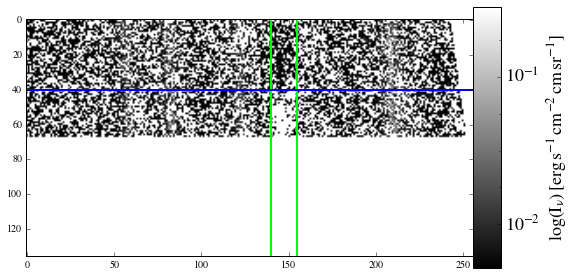

In [126]:
# Trim the raw array
im_trim = im_all[11:147,:]
npix = len(im_trim[:,0])

im_trim_top = im_trim[0:npix/2,:]

coadd_im = np.zeros_like(im_trim)

for i in range(npix/2):
    coadd_im[i,:] = im_trim_top[i,:] - im_trim[i+int(nod_pix),:]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im_plot = ax.imshow(coadd_im, cmap='gray', norm=LogNorm(vmin=0.005, vmax=0.3))

# identify where is the Ne II
ax.axvline(140, color='Lime', linewidth=2)
ax.axvline(155, color='Lime', linewidth=2)

ax.axhline(40, color='b', linewidth=2)

cax = fig.add_axes([0.9, 0.21, 0.05, 0.605])
cb = fig.colorbar(im_plot, cax=cax)
cb.solids.set_edgecolor('face')
cb.ax.minorticks_on()
cb.ax.set_ylabel(r'$\rm{log(I_{\nu})\,[erg\,s^{-1}\,cm^{-2}\,cm\,sr^{-1}]}$',fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=18)


(136, 256)
0.101111


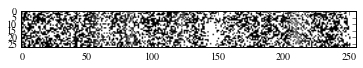

In [149]:
x_pix = np.arange(0,256)

print np.shape(coadd_im)
plt.imshow(coadd_im[40:npix/2,:], cmap='gray', norm=LogNorm(vmin=0.005, vmax=0.3))

print coadd_im[40:npix/2,:].max()

# plt.imshow(coadd_im[40:npix/2,:], cmap='gray', vmin=0.0001, vmax=0.001)

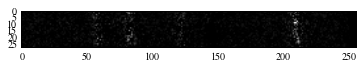

In [148]:
plt.imshow(coadd_im[40:npix/2,:], cmap='gray', vmin=0.0001, vmax=0.1)

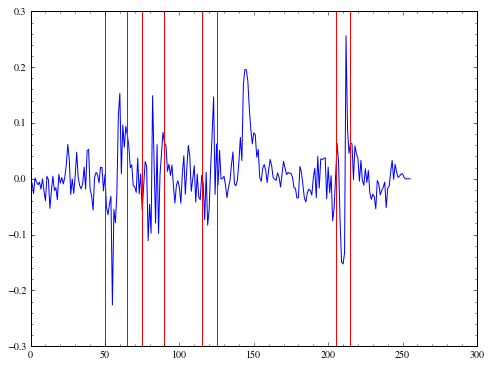

In [156]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(x_pix, -np.sum(coadd_im[40:npix/2,:], axis=0))
coadd_spec = -np.sum(coadd_im[40:npix/2,:], axis=0)

# mask out the tulleric lines
ax.axvline(50, color='r')
ax.axvline(65, color='r')
ax.axvline(75, color='r')
ax.axvline(90, color='r')
ax.axvline(115, color='r')
ax.axvline(125, color='r')
ax.axvline(205, color='r')
ax.axvline(215, color='r')

# identify where is the Ne II
# ax.axvline(140, color='Lime', linewidth=2)
# ax.axvline(155, color='Lime', linewidth=2)
ax.minorticks_on()

0.0263232


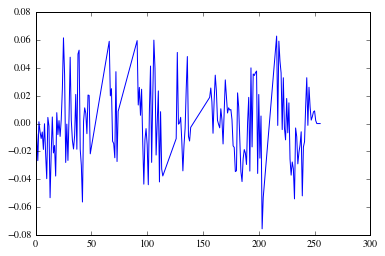

In [164]:
# mask
mask = np.ones_like(coadd_spec, dtype=bool)
for i in range(len(mask)):
    if (i >= 50) & (i <= 65):
        mask[i] = False
    elif (i >= 75) & (i <= 90):
        mask[i] = False
    elif (i >= 115) & (i <= 125):
        mask[i] = False
    elif (i >= 205) & (i <= 215):
        mask[i] = False

line_mask = np.ones_like(coadd_spec, dtype=bool)
for i in range(len(line_mask)):
    if (i >= 140) & (i <= 155):
        line_mask[i] = False
        
plt.plot(x_pix[mask*line_mask], coadd_spec[mask*line_mask])

print np.std(coadd_spec[mask*line_mask])

[   0.18063944  145.32153314    2.97562128]
157.111014324


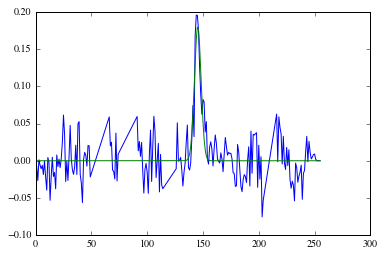

In [176]:
plt.plot(x_pix[mask], coadd_spec[mask])

#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

from scipy.optimize import curve_fit
init = [0.2, 140, 10]
#do the fit!
popt, pcov = curve_fit(gauss_function, x_pix[mask], coadd_spec[mask], p0 = init)
print popt
print popt[2]*res*2.354/12.813548*c/1e5
#plot the fit results
plt.plot(x_pix[mask], gauss_function(x_pix[mask], *popt))

plt.savefig(outdir+'line_fitting.pdf', format='pdf', dpi=300, bbox_inches='tight')

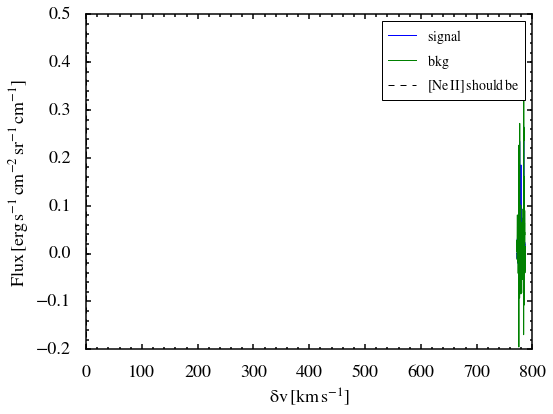

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
# signal, = ax.plot(dv, collapse_im)
signal, = ax.plot(wno, collapse_im)
# bkg, = ax.plot(dv, collapse_bkg*max(collapse_im)/max(collapse_bkg))
bkg, = ax.plot(wno, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
neii = ax.axvline(0, color='k', linestyle='--')

ax.legend([signal, bkg, neii], [r'$\rm{signal}$',r'$\rm{bkg}$',r'$\rm{[Ne\,II]\,should\,be}$'],fontsize=14,numpoints=1)

# ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}\,cm^{-1}]}$', fontsize=18)
ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig(outdir+'hh168_lowall.pdf',dpi=300, bbox_inches='tight',format='pdf')

### Getting the atmospheric line profiles

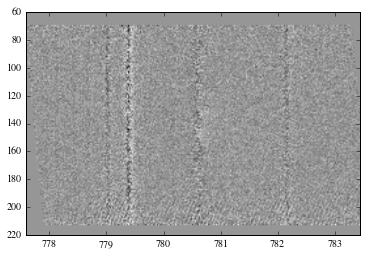

In [263]:
hdulist = fits.open(filename)
im_sub = hdulist[0].data
# 133 is the index of the peak of the blended line, 130 is the peak of the absorption
# 203 is the index of the peak of atmospheric line on the right
# 78 is the index of the absorption peak of the atmospheric line on the left
# use the right line
# im_sub[:,133-10:133+10] = im_sub[:,133-10:133+10] - im_sub[:,202-10:202+10]*1.2
# use the left line
# im_sub[:,130-10:130+10] = im_sub[:,130-10:130+10] - im_sub[:,78-10:78+10]*0.4
atm = 78
ind_sub = 132
offset = 19
for i in range(len(im_sub[:,0])):
    atm_os = np.interp(np.arange(wno[atm-10],wno[atm+11],(wno[atm+11]-wno[atm-10])/220),wno[atm-10:atm+11],im_sub[i,atm-10:atm+11])
    # re-sample the atmospheric line
    reosatm = np.empty_like(im_sub[i,ind_sub-10:ind_sub+10])
    for j in range(len(reosatm)):
        reosatm[j] = atm_os[offset+10*j-1]
    im_sub[i,ind_sub-10:ind_sub+10] = im_sub[i,ind_sub-10:ind_sub+10] - reosatm*0.6
# plt.plot(wno, collapse_im)
# plt.axvline(780.63806152)
# plt.axvline(782.2510376)
# print collapse_im[133]/collapse_im[203]
plt.imshow(im_sub[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')
plt.savefig('/Users/yaolun/test/best_sub_sofar.pdf', format='pdf', dpi=300, bbox_inches='tight')

24.0638


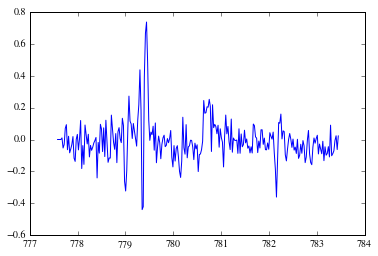

In [272]:
plt.plot(wno, np.sum(im_sub[125:160,:], axis=0))
line_flux = np.sum(np.sum(im_sub[125:160,:], axis=0)[(wno > 780.6) & (wno < 780.9)])
noise = np.std(np.hstack((np.sum(im_sub[125:160,:], axis=0)[(wno > 779.8) & (wno < 780.6)],\
                        np.sum(im_sub[125:160,:], axis=0)[(wno > 780.9) & (wno < 782)])))
print line_flux/noise
# plt.axvline(779.37310791)
# print np.argsort(collapse_im)
# print wno[np.argsort(collapse_im)]

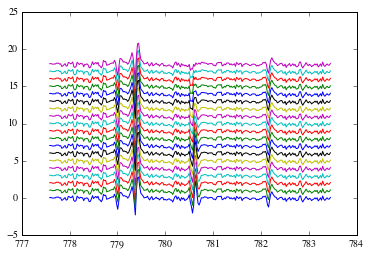

In [257]:
def offset_test(offset):
    hdulist = fits.open(filename)
    im_sub = hdulist[0].data
    # 133 is the index of the peak of the blended line, 130 is the peak of the absorption
    # 203 is the index of the peak of atmospheric line on the right
    # 78 is the index of the absorption peak of the atmospheric line on the left
    # use the right line
    # im_sub[:,133-10:133+10] = im_sub[:,133-10:133+10] - im_sub[:,202-10:202+10]*1.2
    # use the left line
#     im_sub[:,130-10:130+10] = im_sub[:,130-10:130+10] - im_sub[:,78-10:78+10]*0.1
    atm = 78
    ind_sub = 132
    
    for i in range(len(im_sub[:,0])):
        atm_os = np.interp(np.arange(wno[atm-10],wno[atm+11],(wno[atm+11]-wno[atm-10])/220),wno[atm-10:atm+11],im_sub[i,atm-10:atm+11])
        # re-sample the atmospheric line
        reosatm = np.empty_like(im_sub[i,ind_sub-10:ind_sub+10])
        for j in range(len(reosatm)):
            reosatm[j] = atm_os[offset+10*j-1]
        im_sub[i,ind_sub-10:ind_sub+10] = im_sub[i,ind_sub-10:ind_sub+10] - reosatm*0.6
#     plt.imshow(im_sub[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')
    plt.plot(wno, np.sum(im_sub, axis=0)+offset)
for i in range(0,19):
    offset_test(i)

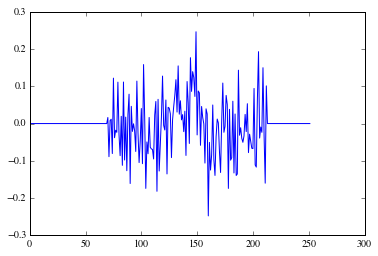

In [264]:
# collpase in wavenumber
flux = np.empty_like(im[:,0])
im_dum = im_sub[:,(wno > 780.5) & (wno < 781)]
for i in range(len(flux)):
    flux[i] = max(im_dum[i,:]) 
flux = np.sum(im_sub[:, (wno > 780.5) & (wno < 781)], axis=1)
plt.plot(flux)
plt.savefig('/Users/yaolun/test/intensity_along_slit.pdf', format='pdf', dpi=300, bbox_inches='tight')

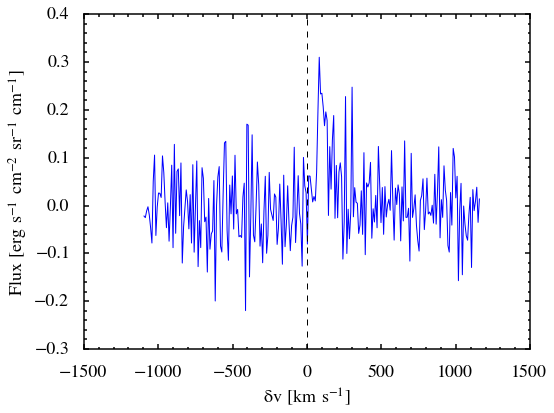

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(dv, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
ax.axvline(0, color='k', linestyle='--')

# ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}\,cm^{-1}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/data/hh168_texes/3003_signal.pdf',dpi=300, bbox_inches='tight',format='pdf')

In [276]:
print hdulist[0].header['RA']
print hdulist[0].header['Dec']
print hdulist[0].header

344.1818
62.09911
SIMPLE  =                    T                                                  BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                  256                                                  NAXIS2  =                  252                                                  EXTEND  =                    T                                                  COMMENT   The primary HDU contains a 2-D spectral-spatial image                 COMMENT   The primary HDU is followed by four 1-D IMAGE extensions              COMMENT   giving the wavenumber scale (EXTNAME = WAVENUMBER),                   COMMENT   the extracted flux spectrum (EXTNAME = FLUX),                         COMMENT   the calculated 1-sigma noise in the flux (NOISE),                     COMMENT   and the telluric transmission spectrum calculated from                COMMENT   (black-sky)/

In [9]:
print hdulist.info()
# print hdulist[3].data

Filename: /Users/yaolun/data/hh168_texes/26/fits/IRXXX     _red.3003.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     121   (256, 252)   float32   
1    WAVENUMBER  ImageHDU         9   (256,)       float32   
2    FLUX        ImageHDU         9   (256,)       float32   
3    NOISE       ImageHDU         9   (256,)       float32   
4    ATMO        ImageHDU         9   (256,)       float32   
5    2-D-NOISE   ImageHDU        11   (256, 252)   float32   
None


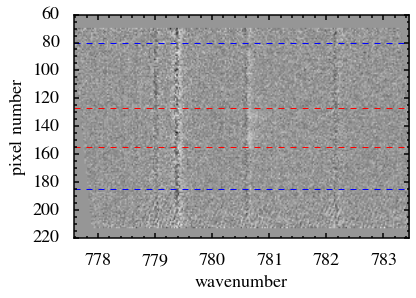

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')
ax.axhline(80, linestyle='--', color='Blue')
ax.axhline(127, linestyle='--', color='Red')
ax.axhline(155, linestyle='--', color='Red')
ax.axhline(185, linestyle='--', color='Blue')

ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
ax.set_ylabel(r'$\rm{pixel\,number}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/data/hh168_texes/3003_2dview_crop.pdf',dpi=300, bbox_inches='tight',format='pdf')

In [52]:
def plot_texes_neii(name, wno=False):

    from astropy.io import fits
    import numpy as np
    import matplotlib.pyplot as plt
    import astropy.constants as const

    c = const.c.cgs.value

    filename = '/Users/yaolun/data/hh168_texes/26/fits/IRXXX     _red.'+name+'.fits'
    hdulist = fits.open(filename)
    im = hdulist[0].data
    wno = hdulist[1].data
    wave = 1/wno *1e4 # in um
    # [Ne II] rest frame wavelength: 12.813548 um
    dv = (12.813548 - wave) / 12.813548 * c/1e5
    collapse_im = np.sum(im[127:155,:], axis=0)
    collapse_bkg = np.sum(im[80:127,:], axis=0)+np.sum(im[155:185,:], axis=0)

    # plot the signal collapsed spectrum and background collapsed spectrum
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if wno:
        signal, = ax.plot(dv, collapse_im)
        bkg, = ax.plot(dv, collapse_bkg*max(collapse_im)/max(collapse_bkg))      
    else:
        signal, = ax.plot(dv, collapse_im)
        bkg, = ax.plot(dv, collapse_bkg*max(collapse_im)/max(collapse_bkg))
    # plt.plot(wno, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
    neii = ax.axvline(0, color='k', linestyle='--')

    ax.legend([signal, bkg, neii], [r'$\rm{signal}$',r'$\rm{bkg}$',r'$\rm{[Ne\,II]\,should\,be}$'],fontsize=14,numpoints=1)

    ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
    ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

    fig.savefig('/Users/yaolun/data/hh168_texes/'+name+'_data.pdf',dpi=300, bbox_inches='tight',format='pdf')
    fig.clf()
    
    # plot the sky subtracted spectrum
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    ax.plot(dv, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
    ax.axvline(0, color='k', linestyle='--')

    ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
    ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

    fig.savefig('/Users/yaolun/data/hh168_texes/'+name+'_signal.pdf',dpi=300, bbox_inches='tight',format='pdf')
    fig.clf()
    
    # plot 2-D spectrum
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(im[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')
    ax.axhline(80, linestyle='--', color='Blue')
    ax.axhline(127, linestyle='--', color='Red')
    ax.axhline(155, linestyle='--', color='Red')
    ax.axhline(185, linestyle='--', color='Blue')

    ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
    ax.set_ylabel(r'$\rm{pixel\,number}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

    fig.savefig('/Users/yaolun/data/hh168_texes/'+name+'_2dview_crop.pdf',dpi=300, bbox_inches='tight',format='pdf')
    fig.clf()
    
    # approximate the [Ne II] flux by adding up flux from wno=780.5 to 781
    im_signal = collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg)
    flux_tot = np.sum(im_signal[(wno >= 780.5) & (wno <= 781)])
    
    return hdulist[0].header['RA'], hdulist[0].header['Dec'], flux_tot

In [53]:
ra = []
dec = []
flux_tot = []
for i in range(3003, 3017):
    ra_dum, dec_dum, flux_dum = plot_texes_neii(str(i))
    ra.append(ra_dum)
    dec.append(dec_dum)
    flux_tot.append(flux_dum)

(14,) (14,) (14,)


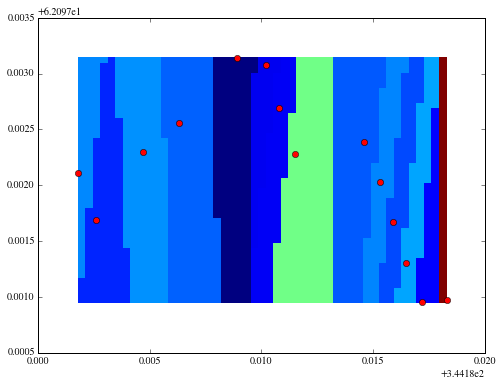

In [38]:
ra = np.array(ra)
dec = np.array(dec)
flux_tot = np.array(flux_tot)
from scipy.interpolate import griddata
x = np.linspace(min(ra), max(ra), 50)
y = np.linspace(min(dec), max(dec), 50)

z = griddata((ra, dec), flux_tot, (x[None,:], y[:,None]), method='nearest')
    
print np.shape(ra), np.shape(dec), np.shape(flux_tot)
# plt.imshow(z)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, z)
ax.plot(ra, dec, 'ro')